In [3]:
using Random, Distributions
using LinearAlgebra
using Gurobi, JuMP
using DataFrames
using CSV
using StatsBase
using Plots
using ProfileSVG

In [4]:
using Profile

In [5]:
# Create a gurobi model without the annoying academic license message
gurobi_env = Gurobi.Env()
function create_gurobi_model(; TimeLimit=-1, LogFile=nothing)
    model = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env)));
    if TimeLimit >= 0
        println("Set Gurobi TimeLimit.")
        set_optimizer_attribute(model, "TimeLimit", TimeLimit)
    end
    if LogFile != nothing
        println("LogFile: $(LogFile).")
        set_optimizer_attribute(model, "LogFile", LogFile)
    else
        set_optimizer_attribute(model, "OutputFlag", 0)
    end
    set_optimizer_attribute(model, "NumericFocus", 3)
    set_optimizer_attribute(model, "Threads", 4)
    return model
end;


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only


_____
# Dual Holistic Regression | Benchmark

## Primal

In [6]:
function compute_primal(X, y, k, γ, t_α, σ_X,log_path)
    
    n, p = size(X)
    
    model = create_gurobi_model(LogFile=log_path)

    # TODO: change big-M values
    M1 = 1000
    M2 = 1000

    @variable(model, β[i=1:p])
    @variable(model, s[i=1:p], Bin)
    @variable(model, b[i=1:p], Bin)

    @constraint(model, sum(s) <= k)
    
    @constraint(model, [i=1:p], β[i] <= M1*s[i])
    @constraint(model, [i=1:p], β[i] >= -M1*s[i])

    @constraint(model, [i=1:p], β[i]/σ_X[i] + M2*b[i] >= t_α*s[i])
    @constraint(model, [i=1:p], -β[i]/σ_X[i] + M2*(1-b[i]) >= t_α*s[i])

    @objective(model, Min, 0.5*sum((y[i] - X[i,:]'β)^2 for i=1:n) + (0.5/γ)* sum(β[j]^2 for j=1:p))
    optimize!(model)
    
    return objective_value(model), value.(β)
end

compute_primal (generic function with 1 method)

_____
## Dual

In [7]:
function g(s, X, y, D, Z, γ, t_α, σ_X)
    
    # Get size
    n, p = size(X)
    
    # Compute norm
    function compute_DZ_square_norm(in_norm)
        return in_norm' * D*Z * in_norm
    end
    
    # Compute max
    model = create_gurobi_model()
    @variable(model, λ[1:p] >= 0)
    
    obj_1 = 0.5*y'y
    obj_2 = t_α*λ'*(s.*σ_X)
    obj_3 = - 0.5 * compute_DZ_square_norm(X'y + λ)
    @objective(model, Max, obj_2 + obj_3)

    optimize!(model)

    # Compute β
    sparsity_indexes = findall(x->x>0, s)
    X_s = X[:, sparsity_indexes]
    λ_s = value.(λ)[sparsity_indexes]
    β_s = (I/γ + X_s'X_s)^(-1)*(X_s'y + λ_s)
    
    β_pred = zeros(p)
    β_pred[sparsity_indexes] = β_s
    return β_pred, value.(λ), objective_value(model) + obj_1
    
end

g (generic function with 1 method)

In [8]:
function ∇g(s, λ, X, y, D, t_α, σ_X)
    n,p = size(X)
    grad = zeros(p)
    
    function compute_DED_square_norm(E,in_norm)
        return in_norm' * D*E*D' * in_norm
    end
    for i in 1:p
        E_ii = Diagonal([(j == i)*1 for j in 1:p])
        grad[i] = t_α*λ'E_ii*σ_X - 0.5*compute_DED_square_norm(E_ii, X'y+ λ)
    end
    return grad
end

∇g (generic function with 1 method)

In [9]:
function compute_dual(X_p, y, k, γ, t_α, σ_X_p, log_path)
    n, p = size(X_p)
    
    # Extended Matrices
    X = hcat(X_p, -X_p)
    M = X'X
    σ_X = [σ_X_p; σ_X_p]
    
    # Outer problem
    miop = create_gurobi_model(LogFile=log_path)
    
    @variable(miop, s[1:2*p], Bin)
    @variable(miop, t >= 0)
    
    @constraint(miop, sum(s) <= k)
    @constraint(miop, [i=1:p], s[i]+s[p+i]<=1)
    
    # Cutting plane
    
    s_init = zeros(2*p)
    s_init[1:k] .= 1
    Z_init = Diagonal(s_init)
    D_init = (I/γ + Z_init*M)^(-1)
    
    β_init, λ_init, g_init = g(s_init, X, y, D_init, Z_init, γ, t_α, σ_X)
    ∇g_init = ∇g(s_init, λ_init, X, y, D_init, t_α, σ_X)
    
    @constraint(miop, t >= g_init + dot(∇g_init, s - s_init))
    @objective(miop, Min, t)
    
    function outer_approximation(cb_data)
        s_val = [callback_value(cb_data, s[i]) for i=1:2*p]
        Z_val = Diagonal(s_val)
        D_val = (I/γ + Z_val*M)^(-1)
        
        β_val, λ_val, g_val = g(s_val, X, y, D_val, Z_val, γ, t_α, σ_X)
        ∇g_val = ∇g(s_val, λ_val, X, y, D_val, t_α, σ_X)
        offset = sum(∇g_val .* s_val)
        con = @build_constraint(t >= g_val + ∇g_val'*s - offset)
        MOI.submit(miop, MOI.LazyConstraint(cb_data), con)
    end
    
    MOI.set(miop, MOI.LazyConstraintCallback(), outer_approximation)
    optimize!(miop)
    
    s_val = JuMP.value.(s)
    Z_val = Diagonal(s_val)
    D_val = (I/γ + Z_val*M)^(-1)
    β_val, λ_val, g_val = g(s_val, X, y, D_val, Z_val, γ, t_α, σ_X)

    β_pred = β_val[1:p] .- β_val[p+1:end]
    return objective_value(miop), β_pred 
end

compute_dual (generic function with 1 method)

____
## Synthetic Data

In [10]:
function generate_synthetic_data(n, p, k, NR)
    
    # Generate PD matrix
    A = randn(p, p)
    A = A'*A
    Σ = (A' + A)/2
    
    # Generate data X
    d = MvNormal(Σ)
    X = rand(d, n)'I
    
    # Split data
    index_train = 1:floor(Int, 0.5*n)
    index_val = floor(Int, 0.5*n)+1:floor(Int, 0.75*n)
    index_test = floor(Int, 0.75*n)+1:n
    
    X_train = X[index_train,:]
    X_val = X[index_val,:]
    X_test = X[index_test,:]
    
    # Center
    μ_train = [mean(X_train[:, j]) for j=1:p]
    for j=1:p
         X_train[:,j] = X_train[:,j] .- μ_train[j]
         X_val[:,j] = X_val[:,j] .- μ_train[j]
         X_test[:,j] = X_test[:,j] .- μ_train[j]
    end
    
    # Scale
    σ_train = [norm(X_train[:, j]) for j=1:p]
    for j=1:p
         X_train[:,j] = X_train[:,j]/σ_train[j]
         X_val[:,j] = X_val[:,j] ./ σ_train[j]
         X_test[:,j] = X_test[:,j] ./ σ_train[j]
    end
    
    # Generate β
    β = zeros(p)
    for j=1:k
        β[floor(Int, j*p/k)] = 1.0*rand([-1, 1])
    end
    
    # Noise
    ϵ = rand(Normal(0, std(X*β)*NR), n)
    
    # Target
    y_train = X_train*β + ϵ[index_train]
    y_val = X_val*β + ϵ[index_val]
    y_test = X_test*β + ϵ[index_test]
            
    return  (X_train, y_train), (X_val, y_val), (X_test, y_test), β
end

generate_synthetic_data (generic function with 1 method)

In [11]:
function get_t_α_and_σ_X(X, y, α, γ)
    n, p = size(X)
    
    # Student law
    t_α = quantile(TDist(n-p), 1 - α/2) # Beware: n-p-1 if we add intercept
    
    # Estimator σ
    M = 1/γ*I + X'X
    M_inv = M^-1
    σ_tilde = sqrt((y'*(I - X*M_inv*X')*y)/(n-p))
    σ_X = σ_tilde * sqrt.(diag(M_inv))
    
    return t_α, σ_X
end

get_t_α_and_σ_X (generic function with 1 method)

In [12]:
function get_insample_R2(y_pred, y_true, p)
    TSE = sum((y_pred[i]-y_true[i])^2 for i=1:p)
    baseline_E = sum((sum(y_true)/length(y_true)-y_true[i])^2 for i=1:p)
    return 1 - TSE/baseline_E
end

function get_OR2(y_pred, y_true, y_train, p)
    TSE = sum((y_pred[i]-y_true[i])^2 for i=1:p)
    baseline_E = sum((sum(y_train)/length(y_train)-y_true[i])^2 for i=1:p)
    return 1 - TSE/baseline_E
end

get_OR2 (generic function with 1 method)

____
## Experiences

In [13]:
n = 2*1000
p = 25
k = 5
NR = 0.01
α = 0.05
γ = 10;

In [10]:
function r(x,dig)
    return round(x,digits = dig)
end

function list2string(list)
    s=""
    for x in list 
        s*=x
    end
    s*="\n"
    return s
end

list2string (generic function with 1 method)

In [11]:
NR = 0.01
α = 0.05
γ = 1;


open("results/results.csv", "w") do io
    write(io, "Algo,n,p,k,γ,NR,α,time,R2,OR2,t_synthetic,t_thresh_var\n")
    for n in [2*10000]
        for p in [10, 25, 50]
            println("n=",n," p=", p)
            k = div(p,2)
            Random.seed!(42)
            t_synthetic = @elapsed (X_train, y_train), (X_val, y_val), (X_test, y_test), β_true = generate_synthetic_data(n, p, k, NR);
            t_thresh_var = @elapsed t_α, σ_X = get_t_α_and_σ_X(X_train, y_train, α, γ)
            
            #solving primal
            println("Solving primal")
            log_path_primal = "logs/Primal_" * string(n) * "_" * string(p) * "_" * string(k) * "_" * string(γ) * ".txt"
            t_primal = @elapsed obj_value, β_primal = compute_primal(X_train, y_train, k, γ, t_α, σ_X, log_path_primal)
            println("Time primal: ", t_primal)
            #solving dual
            println("Solving dual")
            log_path_dual = "logs/Dual_" * string(n) * "_" * string(p) * "_" * string(k) * "_" * string(γ) * ".txt"
            t_dual = @elapsed obj_value, β_dual = compute_dual(X_train, y_train, k, γ, t_α, σ_X, log_path_dual);
            println("Time dual: ", t_dual)
            R2_primal = get_insample_R2(X_train*β_primal, y_train, p)
            R2_dual = get_insample_R2(X_train*β_dual, y_train, p)
            OR2_primal = get_OR2(X_test*β_primal, y_test, y_train, p)
            OR2_dual = get_OR2(X_test*β_dual, y_test, y_train, p)
            
            
            list_primal = [x*"," for x in string.([n/2,p,k,γ,NR,α,
                                r(t_primal,3),r(R2_primal,3),r(OR2_primal,3),r(t_synthetic,3),r(t_thresh_var,3)])]
            s = "Primal,"*list2string(list_primal) 
            write(io, s)
            list_dual = [x*"," for x in string.([n/2,p,k,γ,NR,α,
                                r(t_dual,3),r(R2_dual,3),r(OR2_dual,3),r(t_synthetic,3),r(t_thresh_var,3)])]
            s = "Dual,"*list2string(list_dual) 
            write(io, s)
        end
    end
end
            

n=20000 p=10
Solving primal
LogFile: logs/Primal_20000_10_5_1.txt.
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 41 rows, 30 columns and 110 nonzeros
Model fingerprint: 0xf8c2ab70
Model has 55 quadratic objective terms
Variable types: 10 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-02, 2e+00]
  QObjective range [2e-04, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Found heuristic solution: objective 18.5567606
Presolve time: 0.01s
Presolved: 41 rows, 30 columns, 110 nonzeros
Presolved model has 55 quadratic objective terms
Variable types: 10 continuous, 20 integer (20 binary)

Root relaxation: objective 1.725281e+01, 56 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   17.25281    0   15   18.55676   17.25281  7.03%

Time primal: 59.213170645
Solving dual
LogFile: logs/Dual_20000_50_25_1.txt.
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 52 rows, 101 columns and 301 nonzeros
Model fingerprint: 0x9f0fdb1a
Variable types: 1 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]
Presolve time: 0.00s
Presolved: 52 rows, 101 columns, 301 nonzeros
Variable types: 1 continuous, 100 integer (100 binary)

Root relaxation: objective 4.711196e+02, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  489.16553    0    4          -  489.16553      -     -    0s
     0     2  489.16553    0    4          -  489.16553      -     -    0s
    31    40  494.85892    6    8          -  494.48895      -  31.

Time dual: 2148.58108232


LogFile: logs/Dual_profview.txt.
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 52 rows, 101 columns and 301 nonzeros
Model fingerprint: 0x81dbb562
Variable types: 1 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve time: 0.00s
Presolved: 52 rows, 101 columns, 301 nonzeros
Variable types: 1 continuous, 100 integer (100 binary)

Root relaxation: objective 1.449920e+02, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  144.99201    0    2          -  144.99201      -     -    0s
     0     2  144.99201    0    2          -  144.99201      -     -    1s
*   51    47               7     146.7069349  146.33970  0.25%   6.1    7s
H   85    44                     146

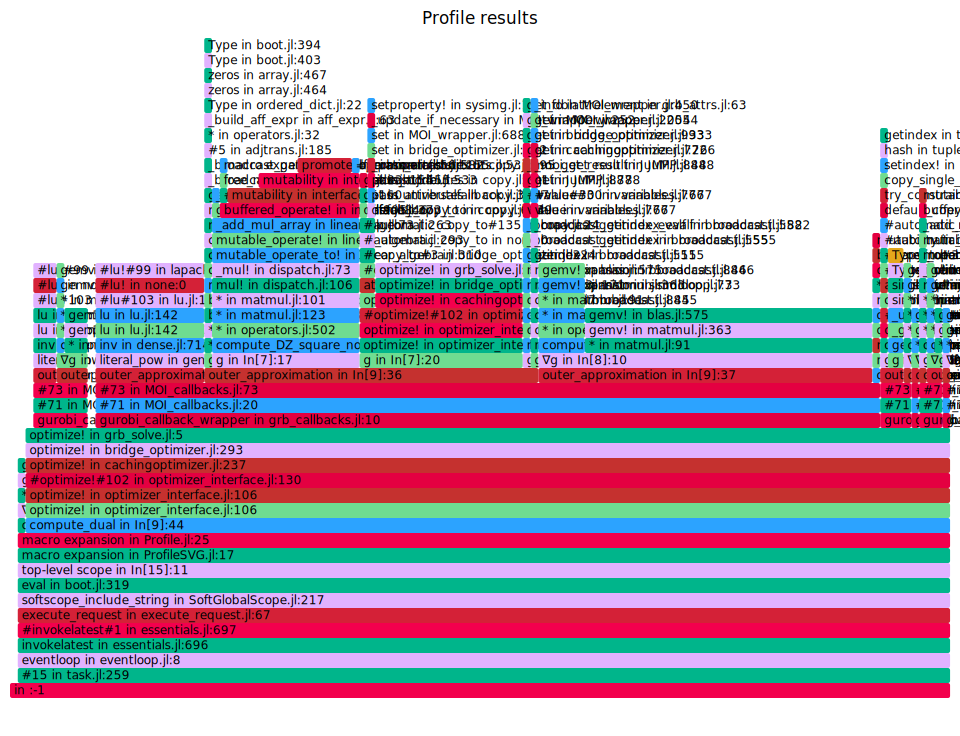

In [15]:
n = 2*10000
p = 50
k = 5
γ = 1
Random.seed!(42)
(X_train, y_train), (X_val, y_val), (X_test, y_test), β_true = generate_synthetic_data(n, p, k, NR);
t_α, σ_X = get_t_α_and_σ_X(X_train, y_train, α, γ)

log_path_dual = "logs/Dual_profview.txt"
Profile.init(n = 10^7, delay = 0.1)
@profview obj_value, β_dual = compute_dual(X_train, y_train, k, γ, t_α, σ_X, log_path_dual)

In [12]:
hcat(β_true, β_primal)

UndefVarError: UndefVarError: β_true not defined

In [31]:
hcat(β_true, β_dual)

12×2 Array{Float64,2}:
  0.0   0.0     
 -1.0  -0.994932
  0.0   0.0     
 -1.0  -0.95602 
  0.0   0.0     
  0.0   0.0     
 -1.0  -1.01083 
  0.0   0.0     
 -1.0  -0.860458
  0.0   0.0     
  0.0   0.0     
  1.0   0.852981

0.07644200018898462

0.07644200019152847

-0.14067926932272168

-0.14067926941381903